In [8]:
import pandas as pd
import re, urllib, html
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import spacy
nlp = spacy.load("en_core_web_sm") ## load English model and instantiate

## EDA and Preprocessing : `LanguageTechnology` (Natural Language Processing)

#### subreddit : /r/LanguageTechnology

- `LanguageTechnology.json` : all data that contains records without post text
- `LanguageTechnology_withtext.json` : after dropping records without post text

In [27]:
## load data
df = pd.read_json(f'../data/LanguageTechnology.json').drop_duplicates()
df_withtext = pd.read_json(f'../data/LanguageTechnology_withtext.json').drop_duplicates()

display(df) # 5821 records
display(df_withtext) # 3473 records

,vote,title,text,date
0,1,An Emirati girl publishes books to help kids w...,None,2023-10-23
1,8,Do you have a specific hypothesis you would li...,[deleted],2023-07-05
2,1,Empowering Remote Work with Azure Virtual Desktop,None,2023-06-11
3,1,Why Not Ternary Computers? - Laptotech,None,2023-06-11
4,3,"The ""Memory-efficient NLLB-200: Language-speci...",The paper\n promises to release it:\n> We will...,2023-06-10
...,...,...,...,...
5825,1,Interlingual Machine Translation,None,2010-10-07
5826,1,Parts-Of-Speech Tagging,None,2010-03-13
5827,1,Maximum Entropy,None,2010-03-13
5828,1,Tokenization,None,2010-03-10


,vote,title,text,date
0,3,"The ""Memory-efficient NLLB-200: Language-speci...",The paper\n promises to release it:\n> We will...,2023-06-10
1,2,Seeking Suggestions: Enhancing Chat Interactio...,There are numerous plugins available for ChatG...,2023-06-10
2,44,/r/LanguageTechnology will be joining the prot...,On June 12th /r/LanguageTechnology will join t...,2023-06-10
3,49,Introducing SlimPajama-627B: the largest exten...,SlimPajama cleans and deduplicates RedPajama-1...,2023-06-09
4,0,Philosophy blender: Using ChatGPT to create no...,Check out my newest program: Philosophy Blend...,2023-06-09
...,...,...,...,...
3468,1,What are some good resources for doing clause ...,"Books, favorite websites/blogs, etc. I'm goin...",2012-08-06
3469,6,Is it possible to algorithmically rank words b...,"A word is highly ""spellable"" if a high percent...",2012-05-01
3470,3,What is the most accurate method in paraphrase...,I've gone through most of the literature and i...,2011-12-24
3471,1,Handling metaphors,I am working on a project in which i need to d...,2011-11-20


#### check null

In [28]:
print(df.isna().sum())
print('\n')
print(df_withtext.isna().sum())

vote        0
title       0
text     1507
date        0
dtype: int64


vote     0
title    0
text     0
date     0
dtype: int64


#### fill null with empty string `''`

In [29]:
df['text'].fillna('', inplace=True)

#### check length of title and text (character length)

In [30]:
len_df = pd.concat([df['title'].str.len(), df['text'].str.len()], axis=1)
len_df.describe()

,title,text
count,5821.000000,5821.000000
mean,61.147054,409.956365
std,36.656481,805.009663
min,2.000000,0.000000
25%,38.000000,0.000000
50%,54.000000,227.000000
75%,77.000000,567.000000
max,302.000000,24866.000000


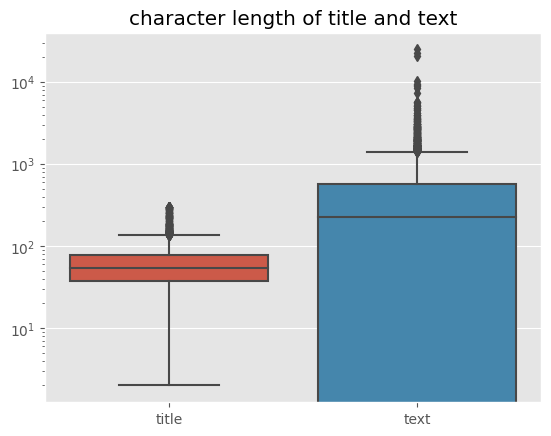

In [31]:
sns.boxplot(data=len_df)
plt.yscale('log')
plt.title('character length of title and text');

#### records with character length less than 20

In [32]:
df[len_df['text'] < 20]['text'].value_counts()

                       1507
[deleted]               500
[removed]               341
what the title says       1
(and why)                 1
Many thanks.              1
Looking for some.         1
Name: text, dtype: int64

#### replace `[deleted]` and `[removed]` with empty string, then combine title and text

In [33]:
df['text'].replace('[removed]', '', inplace=True)
df['text'].replace('[deleted]', '', inplace=True)

df['all_text'] = df['title'] + ' ' + df['text']
df['all_text']

0       An Emirati girl publishes books to help kids w...
1       Do you have a specific hypothesis you would li...
2       Empowering Remote Work with Azure Virtual Desk...
3                 Why Not Ternary Computers? - Laptotech 
4       The "Memory-efficient NLLB-200: Language-speci...
                              ...                        
5825                    Interlingual Machine Translation 
5826                             Parts-Of-Speech Tagging 
5827                                     Maximum Entropy 
5828                                        Tokenization 
5829                   Example based machine translation 
Name: all_text, Length: 5821, dtype: object

#### tokenization with `Spacy`

- remove URLs
- replace `'\n'` with single space `' '`
- remove punctuation
- remove OR not remove stopwords (compare 2 version)

In [34]:
def tokenize(text, remove_stop=True):
    text = html.unescape(urllib.parse.unquote(text)) # unescape for unicode, unquote for escaped URL
    text = re.sub(r'https?.+?(?:\s|$)', '', text) # remove URL link
    text = re.sub(r'[\n\t \u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space

    doc = nlp(text)
    if remove_stop == True:
        return [token.lemma_ for token in doc if token.is_stop == False and token.is_punct == False]
    else:
        return [token.lemma_ for token in doc if token.is_punct == False]

df['token_with_stop'] = df['all_text'].apply(lambda x: tokenize(x, False))
df['token_w/o_stop'] = df['all_text'].apply(lambda x: tokenize(x, True))

#### count word frequency

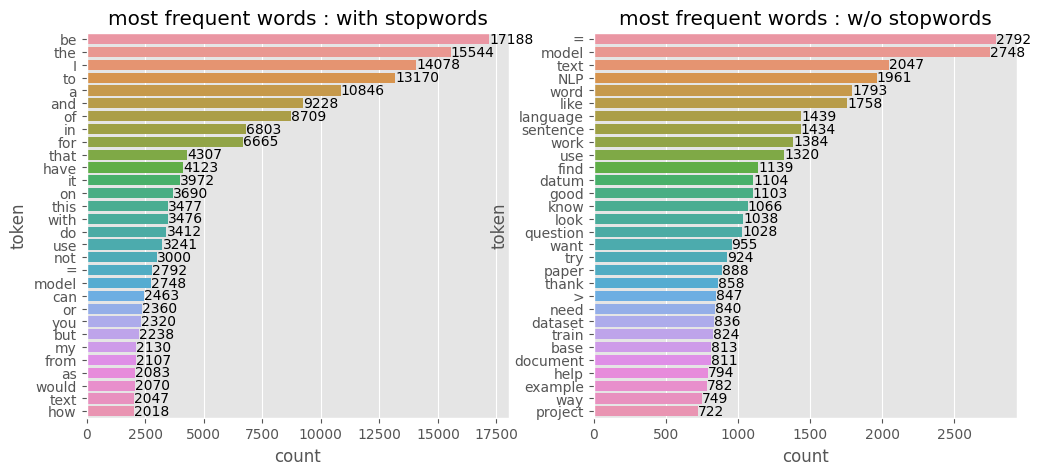

In [35]:
token_count_with_stop = Counter()
token_count_with_stop.update(sum(df['token_with_stop'], [])) # flattened 1D list of tokens

token_count_without_stop = Counter()
token_count_without_stop.update(sum(df['token_w/o_stop'], [])) # flattened 1D list of tokens

## Visualize
plt.figure(figsize=(12,5))

## count plot of tokens including stopwords
plt.subplot(1,2,1)
ax = sns.barplot(x='count', y='token', data=pd.DataFrame(token_count_with_stop.most_common(30), columns=['token','count']))
ax.bar_label(ax.containers[0])
plt.title('most frequent words : with stopwords')

## count plot of tokens removing stopwords
plt.subplot(1,2,2)
ax = sns.barplot(x='count', y='token', data=pd.DataFrame(token_count_without_stop.most_common(30), columns=['token','count']))
ax.bar_label(ax.containers[0])
plt.title('most frequent words : w/o stopwords');

## EDA and Preprocessing : `NLP` (Neuro Linguistic Programming)

#### subreddit : /r/NLP

- `NLP.json` : all data that contains records without post text
- `NLP_withtext.json` : after dropping records without post text

In [17]:
df = pd.read_json(f'../data/NLP.json').drop_duplicates()
df_withtext = pd.read_json(f'../data/NLP_withtext.json').drop_duplicates()

display(df) # 1927 records
display(df_withtext) # 448 records

,vote,title,text,date
0,1,Modelling. Part #4 of the REAL history of NLP,None,2023-10-23
1,2,Fast phobia cure audio,I am looking for a fast phobia cure audio for ...,2023-06-08
2,1,HashiCorp Vault + NLP (How To Approach?),[removed],2023-06-08
3,6,New trying to figure out if NLP will help me,I am somewhat familiar with NLP. I had a frien...,2023-06-06
4,1,Discord Server,Anyone know what happened to the NLP Discord s...,2023-06-06
...,...,...,...,...
1926,5,Let's argue: I think NLP is bullshit.,fists up,2010-12-30
1927,10,Neuro-Linguistic Programming: Recommended reading,Below follows a list of books I know have been...,2010-09-24
1928,1,Salad Ltd: A series of videos as a taster to NLP,None,2010-09-21
1929,1,Timeline therapy works!,None,2010-07-03


,vote,title,text,date
0,2,Fast phobia cure audio,I am looking for a fast phobia cure audio for ...,2023-06-08
1,6,New trying to figure out if NLP will help me,I am somewhat familiar with NLP. I had a frien...,2023-06-06
2,1,Discord Server,Anyone know what happened to the NLP Discord s...,2023-06-06
3,5,Techniques for vicarious embarrassment,I am an NLP newbie - my experience is limited ...,2023-06-01
4,2,Is there anyone who is familiar with ACT-R mod...,If you’re familiar with ACT-r please direct me...,2023-05-28
...,...,...,...,...
443,1,"self-made reframing technique - your critique,...","OK, this is for when you know someone has lied...",2011-08-03
444,1,Should I subscribe? Too soon?,I have been recently introduced to the world o...,2011-07-12
445,2,Using Python for Morphological Parsing?,My research project this summer is to attempt ...,2011-05-25
446,5,Let's argue: I think NLP is bullshit.,fists up,2010-12-30


#### check null and fillna

In [18]:
print(df.isna().sum())
print('\n')
print(df_withtext.isna().sum())

## replace null with empty string
df['text'].fillna('', inplace=True)

vote       0
title      0
text     891
date       0
dtype: int64


vote     0
title    0
text     0
date     0
dtype: int64


#### check length of title and text (character length)

In [4]:
len_df = pd.concat([df['title'].str.len(), df['text'].str.len()], axis=1)
len_df.describe()

,title,text
count,1927.000000,1036.000000
mean,54.147898,294.666023
std,37.039319,739.186737
min,2.000000,7.000000
25%,30.000000,9.000000
50%,46.000000,9.000000
75%,69.000000,307.000000
max,307.000000,7730.000000


#### replace `[deleted]` and `[removed]` with empty string, then combine title and text

In [20]:
df['text'].replace('[removed]', '', inplace=True)
df['text'].replace('[deleted]', '', inplace=True)

df['all_text'] = df['title'] + ' ' + df['text']
df['all_text']

0          Modelling. Part #4 of the REAL history of NLP 
1       Fast phobia cure audio I am looking for a fast...
2               HashiCorp Vault + NLP (How To Approach?) 
3       New trying to figure out if NLP will help me I...
4       Discord Server Anyone know what happened to th...
                              ...                        
1926       Let's argue: I think NLP is bullshit. fists up
1927    Neuro-Linguistic Programming: Recommended read...
1928    Salad Ltd: A series of videos as a taster to NLP 
1929                             Timeline therapy works! 
1930    Art Giser Interview: How to Retrieve Your Energy 
Name: all_text, Length: 1927, dtype: object

#### tokenization

In [22]:
df['token_with_stop'] = df['all_text'].apply(lambda x: tokenize(x, False))
df['token_w/o_stop'] = df['all_text'].apply(lambda x: tokenize(x, True))

#### count word frequency

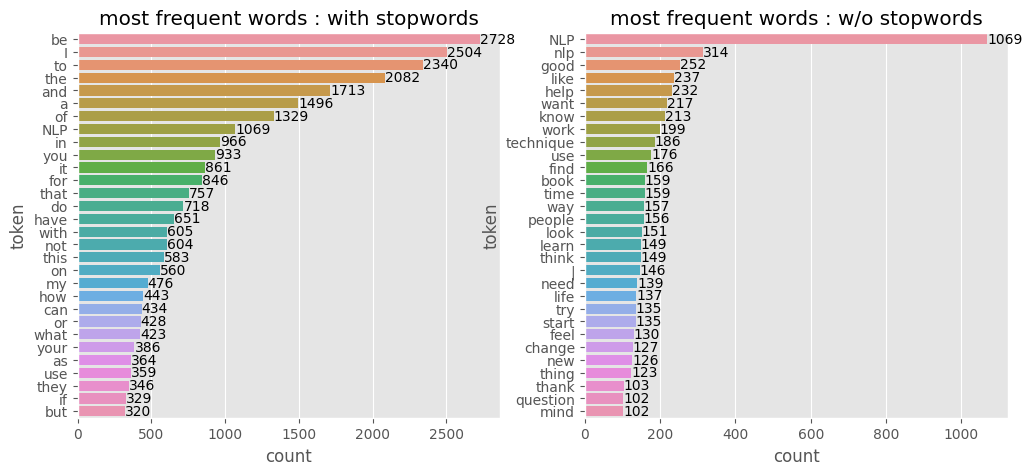

In [26]:
token_count_with_stop = Counter()
token_count_with_stop.update(sum(df['token_with_stop'], [])) # flattened 1D list of tokens

token_count_without_stop = Counter()
token_count_without_stop.update(sum(df['token_w/o_stop'], [])) # flattened 1D list of tokens

## Visualize
plt.figure(figsize=(12,5))

## count plot of tokens including stopwords
plt.subplot(1,2,1)
ax = sns.barplot(x='count', y='token', data=pd.DataFrame(token_count_with_stop.most_common(30), columns=['token','count']))
ax.bar_label(ax.containers[0])
plt.title('most frequent words : with stopwords')

## count plot of tokens removing stopwords
plt.subplot(1,2,2)
ax = sns.barplot(x='count', y='token', data=pd.DataFrame(token_count_without_stop.most_common(30), columns=['token','count']))
ax.bar_label(ax.containers[0])
plt.title('most frequent words : w/o stopwords');

In [36]:
df

,vote,title,text,date,all_text,token_with_stop,token_w/o_stop
0,1,An Emirati girl publishes books to help kids w...,,2023-10-23,An Emirati girl publishes books to help kids w...,"[an, Emirati, girl, publish, book, to, help, k...","[Emirati, girl, publish, book, help, kid, autism]"
1,8,Do you have a specific hypothesis you would li...,,2023-07-05,Do you have a specific hypothesis you would li...,"[do, you, have, a, specific, hypothesis, you, ...","[specific, hypothesis, like, test, time]"
2,1,Empowering Remote Work with Azure Virtual Desktop,,2023-06-11,Empowering Remote Work with Azure Virtual Desk...,"[empower, Remote, Work, with, Azure, Virtual, ...","[empower, Remote, Work, Azure, Virtual, Desktop]"
3,1,Why Not Ternary Computers? - Laptotech,,2023-06-11,Why Not Ternary Computers? - Laptotech,"[why, not, Ternary, Computers, Laptotech]","[Ternary, Computers, Laptotech]"
4,3,"The ""Memory-efficient NLLB-200: Language-speci...",The paper\n promises to release it:\n> We will...,2023-06-10,"The ""Memory-efficient NLLB-200: Language-speci...","[the, memory, efficient, NLLB-200, language, s...","[memory, efficient, NLLB-200, language, specif..."
...,...,...,...,...,...,...,...
5825,1,Interlingual Machine Translation,,2010-10-07,Interlingual Machine Translation,"[Interlingual, Machine, Translation]","[Interlingual, Machine, Translation]"
5826,1,Parts-Of-Speech Tagging,,2010-03-13,Parts-Of-Speech Tagging,"[part, of, Speech, Tagging]","[part, Speech, Tagging]"
5827,1,Maximum Entropy,,2010-03-13,Maximum Entropy,"[Maximum, Entropy]","[Maximum, Entropy]"
5828,1,Tokenization,,2010-03-10,Tokenization,[tokenization],[tokenization]
